# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as nr
import seaborn as sns

# Default parameters

In [2]:
plt.rcParams.update({'figure.figsize':(6.5, 3.5), 'figure.dpi':120})

In [3]:
# The random seed.
seed = 0

# The time interval [0, T].
T = 2

# The number of grid points in the time interval.
N = 10**5

# Brownian motion

Consider a uniform grid on the interval $[0,T]$:
\begin{gather*}
0=t_0<t_1<t_2<\ldots<t_N=T,\\
t_n=\dfrac{n}{N}T,\quad n=0,1,2,\ldots,N.
\end{gather*}
A discrete approximation $W_N$ of a Brownian motion $W$ on $[0,T]$ can be constructed as a piecewise linear function with the values at the grid points given by
\begin{gather*}
W_N(t_0)=0,\\
W_N(t_n)=\sum_{i=1}^n \varepsilon_i\sqrt{\Delta t_i},\quad n=1,2,\ldots,N,\\
\Delta t_i=t_i-t_{i-1},\quad i=1,2,\ldots,N,
\end{gather*}
where $\varepsilon_1,\varepsilon_2,\ldots,\varepsilon_N$ are i.i.d. random variables with the standard normal distribution $\mathcal{N}(0,1)$.

In [4]:
def Brownian_motion(ts, seed=None):
    if seed != None:
        nr.seed(seed)
    
    increments = np.diff(ts) # same as ts[1:] - ts[:-1]
    Ws = np.cumsum(np.sqrt(increments) * nr.normal(loc=0, scale=1, size=len(increments)))
    Ws = np.r_[0, Ws]
    
    return Ws

In [5]:
ts = np.linspace(0, T, N+1, endpoint=True)
Ws = Brownian_motion(ts, seed=seed)

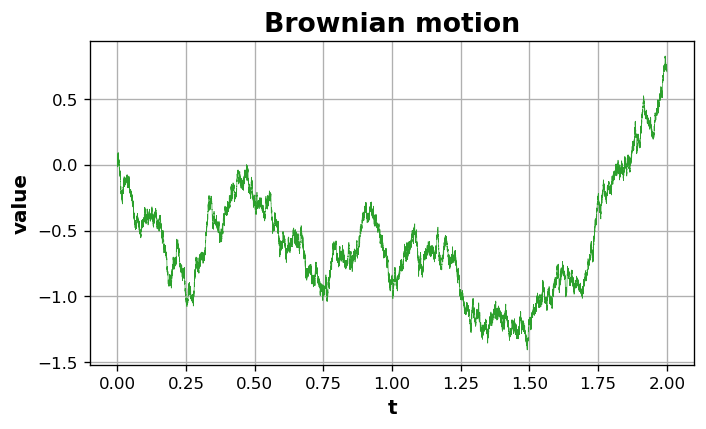

In [6]:
plt.plot(ts, Ws, color="tab:green", lw=0.4)
plt.grid(0.5)
plt.xlabel("t", fontdict={"size":12, "weight":"bold"})
plt.ylabel("value", fontdict={"size":12, "weight":"bold"})
plt.title("Brownian motion", fontdict={"size":16, "weight":"bold"})
plt.show()

# Itô processes

A stochastic process $X_t$ is called an Itô process if it can be represented as
$$
X_t=X_0+\int_0^t A_s\,ds+\int_0^t B_s\,dW_s,\quad t\geqslant 0,
$$
where $X_0$ is the starting point, $A=A_t$ is the drift coefficient, and $B=B_t$ is the diffusion coefficient. If $X_t$ is an Itô process, the above formula is often written in the differential form:
$$
dX_t=A_tdt+B_tdW_t,\quad t\geqslant 0,
$$
and the initial value $X_0$ is specified separately. However, the differential form is just shorthand for the integral form.

A discrete approximation of the Itô process $X_t$ can be constructed as
$$
X_{t_n}=X_0+\sum_{i=1}^n A_{t_{i-1}}\Delta t_i+\sum_{i=1}^n B_{t_{i-1}}\Delta W_{t_i},\quad n=0,1,2,\ldots,N,
$$
where $\Delta W_{t_i}=W_{t_i}-W_{t_{i-1}}$, $i=1,2,\ldots,N$.

In the example below we consider $A_t=t$ and $B_t=1$.

In [7]:
def Lebesgue_integral(ts, As):
    increments = np.diff(ts)
    integral_values = np.r_[0, np.cumsum(As[:-1] * increments)]
    return integral_values


def Ito_integral(ts, Bs, seed=None):
    Ws = Brownian_motion(ts, seed=seed)
    increments = np.diff(Ws)
    integral_values = np.r_[0, np.cumsum(Bs[:-1] * increments)]
    return integral_values


def Ito_process(ts, As, Bs, X0, seed=None):
    drift = Lebesgue_integral(ts, As)
    diffusion = Ito_integral(ts, Bs, seed=seed)
    vals = X0 + drift + diffusion
    return vals

In [8]:
# @np.vectorize is a so-called decorator.
# It allows to use functions that take scalar arguments on NumPy arrays.

# Drift coefficient
@np.vectorize
def A(t):
    return t

# Diffusion coefficient
@np.vectorize
def B(t):
    return 1

In [9]:
X0 = 0
ts = np.linspace(0, T, N+1)
As = A(ts)
Bs = B(ts)

Xs = Ito_process(ts, As, Bs, X0, seed=seed)
drift = Lebesgue_integral(ts, As)

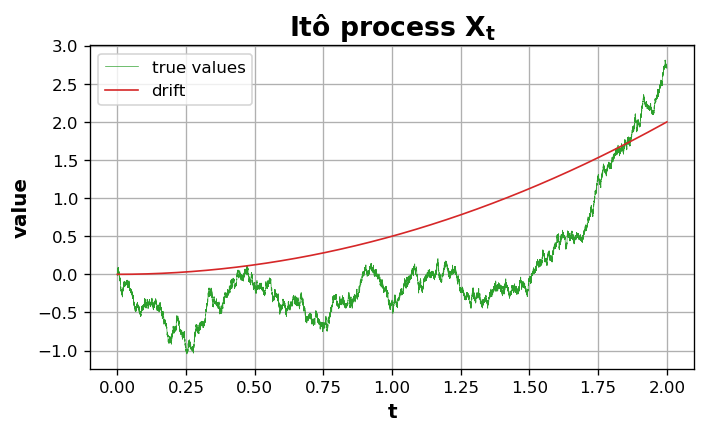

In [10]:
plt.plot(ts, Xs, color="tab:green", lw=0.4, label="true values")
plt.plot(ts, X0 + drift, color="tab:red", lw=1, label="drift")
plt.grid(0.5)
plt.xlabel("t", fontdict={"size":12, "weight":"bold"})
plt.ylabel("value", fontdict={"size":12, "weight":"bold"})
plt.title(r"Itô process $\mathbf{X_t}$", fontdict={"size":16, "weight":"bold"})
plt.legend()
plt.show()

# Itô formula

### Formulation

For a stochastic process $X_t$ given by
$$
X_t=X_0+\int_0^t A_s\,ds+\int_0^t B_s\,dW_s,\quad t\geqslant 0,
$$
and any smooth function $f$, we could expect to have
$$
f(X_t)=f(X_0)+\int_0^t f'(X_s)A_s\,ds+\int_0^t f'(X_s)B_s\,dW_s,\quad t\geqslant 0.
$$
However, the Itô integral has slightly different properties than the Riemann or Lebesgue integrals, and it turns out that the Itô formula holds:
$$
f(X_t)=f(X_0)+\int_0^t \left(f'(X_s)A_s+\dfrac{1}{2}f''(X_s)B_s^2\right)\,ds+\int_0^t f'(X_s)B_s\,dW_s,\quad t\geqslant 0.
$$
In the example below, we consider $A_t$ and $B_t$ as above and take $f(x)=x^2$.

In [11]:
# Transformation
@np.vectorize
def f(x):
    return x**2

# First derivative
@np.vectorize
def f1(x):
    return 2 * x

# Second derivative
@np.vectorize
def f2(x):
    return 2

In [12]:
true_vals = f(Xs)


standard_f_As = f1(Xs) * As
standard_f_Bs = f1(Xs) * Bs
standard_vals = Ito_process(ts, standard_f_As, standard_f_Bs, f(Xs[0]), seed)


Ito_f_As = f1(Xs) * As + 1/2 * f2(Xs) * Bs**2
Ito_f_Bs = f1(Xs) * Bs
Ito_vals = Ito_process(ts, Ito_f_As, Ito_f_Bs, f(Xs[0]), seed)

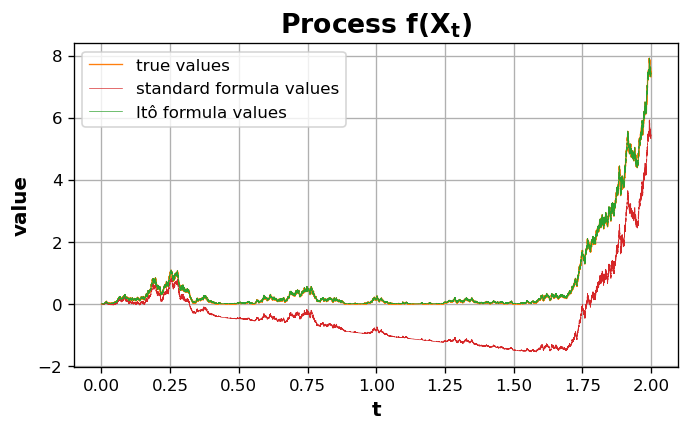

In [13]:
plt.plot(ts, true_vals, color="tab:orange", lw=0.8, label=r"true values")
plt.plot(ts, standard_vals, color="tab:red", lw=0.4, label="standard formula values")
plt.plot(ts, Ito_vals, color="tab:green", lw=0.4, label="Itô formula values")
plt.grid(0.5)
plt.xlabel("t", fontdict={"size":12, "weight":"bold"})
plt.ylabel("value", fontdict={"size":12, "weight":"bold"})
plt.title(r"Process $\mathbf{f(X_t)}$", fontdict={"size":16, "weight":"bold"})
plt.legend()
plt.show()

In [14]:
standard_max_abs = np.max(np.abs(true_vals - standard_vals))
Ito_max_abs = np.max(np.abs(true_vals - Ito_vals))

print("\033[1;4mMaximal absolute error:\033[0m")
print(f"standard formula values: {standard_max_abs:10.5f}")
print(f"Itô formula values: {Ito_max_abs:15.5f}")


standard_mae = np.mean(np.abs(true_vals - standard_vals))
Ito_mae = np.mean(np.abs(true_vals - Ito_vals))

print()
print("\033[1;4mMean absolute error:\033[0m")
print(f"standard formula values: {standard_mae:10.5f}")
print(f"Itô formula values: {Ito_mae:15.5f}")

Maximal absolute error:
standard formula values:    1.98954
Itô formula values:         0.01281

Mean absolute error:
standard formula values:    0.99220
Itô formula values:         0.00780


### Example 1: squared Brownian motion

According to the Itô formula, it holds
$$
W_t^2=t+2\int_0^t W_s\,dW_s,\quad t\geqslant 0,
$$
or equivalently
$$
\int_0^t W_s\,dW_s=\dfrac{1}{2}(W_t^2-t),\quad t\geqslant 0.
$$

This formula can also be checked by computing the integral as a limit of the corresponding integral sums. Indeed, noting that
\begin{gather}
\sum_{i=0}^{n-1} x_{i+1}(x_{i+1}-x_i)+\sum_{i=0}^{n-1} x_i(x_{i+1}-x_i)=x_n^2-x_0^2,\\
\sum_{i=0}^{n-1} x_{i+1}(x_{i+1}-x_i)-\sum_{i=0}^{n-1} x_i(x_{i+1}-x_i)=\sum_{i=0}^{n-1} (x_{i+1}-x_i)^2,
\end{gather}
for any sequence $x_0,x_1,\ldots,x_n$, we can write
$$
\sum_{i=0}^{n-1} x_i(x_{i+1}-x_i)=\dfrac{1}{2}\left[(x_n^2-x_0^2)-\sum_{i=0}^{n-1} (x_{i+1}-x_i)^2\right].
$$
Then, taking $x_i=W_{s_i}$, $0\leqslant i\leqslant n$, with $0=s_0<s_1<\ldots<s_n=t$, we obtain
$$
\sum_{i=0}^{n-1} W_{s_i}(W_{s_{i+1}}-W_{s_i})=\dfrac{1}{2}\left[(W_t^2-W_0^2)-\sum_{k=0}^{n-1} (W_{s_{i+1}}-W_{s_i})^2\right]\xrightarrow{L^2}\dfrac{1}{2}(W_t^2-t),\quad n\to\infty.
$$
Since the integral sum on the left converges to the corresponding Itô integral, equating both expressions leads to the stated equality.

In [15]:
ts = np.linspace(0, T, N+1, endpoint=True)
Ws = Brownian_motion(ts, seed=seed)
X1s = Ito_integral(ts, Ws, seed=seed)
X2s = 1/2 * (np.square(Ws) - ts)

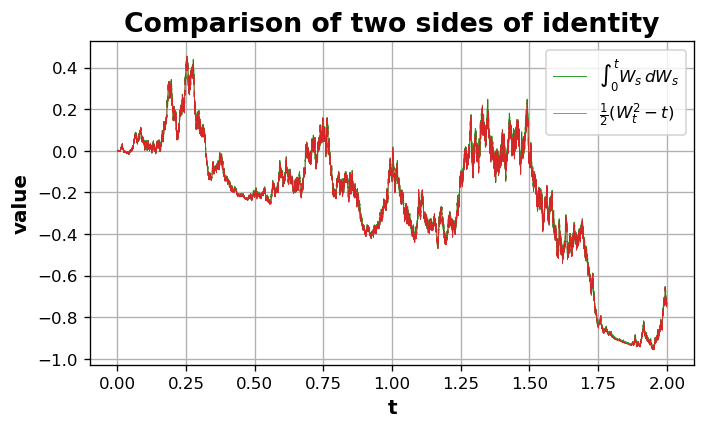

In [16]:
plt.plot(ts, X1s, color="tab:green", lw=0.6, label=r"$\int_0^t W_s\,dW_s$")
plt.plot(ts, X2s, color="tab:red", lw=0.4, label=r"$\frac{1}{2}(W_t^2-t)$")
plt.grid(0.5)
plt.xlabel("t", fontdict={"size":12, "weight":"bold"})
plt.ylabel("value", fontdict={"size":12, "weight":"bold"})
plt.title("Comparison of two sides of identity", fontdict={"size":16, "weight":"bold"})
plt.legend()
plt.show()

### Example 2: geometric Brownian motion

The solution of the stochastic differential equation
$$
dS_t=\mu S_t\,dt+\sigma S_t\,dW_t,\quad t\geqslant 0,
$$
is called a geometric Brownian motion. It can be shown that this equation has a unique solution for all values of parameters $\mu$ and $\sigma$ and any starting point $S_0$. An explicit form of this solution can be found with the help of the Itô formula.

Suppose that $S_0>0$ and that the solution $S_t$ is positive. Then, applying the Itô formula to the Itô process
$$
S_t=S_0+\int_0^t \mu S_s\,ds+\int_0^t \sigma S_s\,dW_s,\quad t\geqslant 0,
$$
and the function $f(x)=\ln x$, we obtain
\begin{equation*}
\begin{aligned}
\ln S_t&=\ln S_0+\int_0^t \left[f'(S_s)\cdot\mu S_s+\dfrac{1}{2}f''(S_s)\cdot\sigma^2S_s^2\right]\,ds+\int_0^t f'(S_s)\cdot\sigma S_s\,dW_s=\\
&=\ln S_0+\int_0^t \left(\mu-\dfrac{\sigma^2}{2}\right)\,ds+\int_0^t \sigma\,dW_s=\\
&=\ln S_0+\left(\mu-\dfrac{\sigma^2}{2}\right)t+\sigma W_t.
\end{aligned}
\end{equation*}
Therefore, exponentiating both sides we conclude that
$$
S_t=S_0\exp\left[\left(\mu-\dfrac{1}{2}\sigma^2\right)t+\sigma W_t\right],\quad t\geqslant 0.
$$

In [17]:
def geometric_Brownian_motion(ts, mu, sigma, S0, seed=None):
    Ws = Brownian_motion(ts, seed=seed)
    vals = S0 * np.exp((mu - 1/2 * sigma**2) * ts + sigma * Ws)
    return vals

In [18]:
mu = 0.8
sigma = 0.5
S0 = 1

ts = np.linspace(0, T, N+1, endpoint=True)
gBms = geometric_Brownian_motion(ts, mu, sigma, S0, seed=seed)

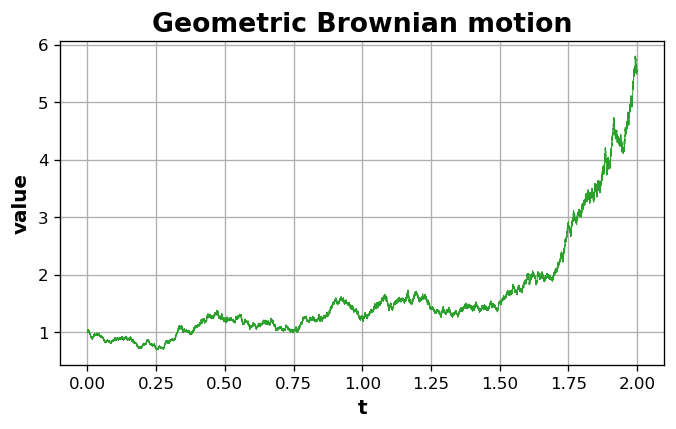

In [19]:
plt.plot(ts, gBms, color="tab:green", lw=0.6)
plt.grid(0.5)
plt.xlabel("t", fontdict={"size":12, "weight":"bold"})
plt.ylabel("value", fontdict={"size":12, "weight":"bold"})
plt.title("Geometric Brownian motion", fontdict={"size":16, "weight":"bold"})
plt.show()

# Interest rate models

There exist several one-factor interest rate models that are defined using stochastic differential equations. They are called one-factor models because they include only one source of noise influencing the interest rate. This noise is modelled by the Wiener process.

The most basic models are:
- **the Vasicek model**,
- **the Black-Karasinksi model**,
- **the Cox-Ingersoll-Ross model**.

The process in the Vasicek model is a generalisation of **the Ornstein-Uhlenbeck process**.

### Vasicek model

The **Vasicek model** is defined by the stochastic differential equation (SDE)
$$
dr_t=a(b-r_t)\,dt+\sigma\,dW_t,\quad t\geqslant 0,
$$
with initial condition $r_0>0$. The coefficients $a$, $b$ and $\sigma$ are called the **speed of reversion**, the **long-term mean level** and the **instantaneous volatility**, respectively.

In the integral form, this equation can be written as
$$
r_t=r_0+\int_0^t a(b-r_s)\,ds+\int_0^t \sigma\,dW_s,\quad t\geqslant 0.
$$
Comparing this formula with the one in the definition of an Itô process, we see that $r_t$ is an Itô process with coefficients
$$
A_t=a(b-r_t),\quad B_t=\sigma.
$$

To solve the equation, we will use a more general version of the Itô formula, which states that for the above Itô process $X_t$ and any smooth function $f\colon [0,+\infty)\times\mathbb{R}\to\mathbb{R}$, it holds
$$
f(t,X_t)=f(0,X_0)+\int_0^t \left(\dfrac{\partial f}{\partial t}(s,X_s)+A_s\dfrac{\partial f}{\partial x}(s,X_s)+\dfrac{B_s^2}{2}\dfrac{\partial^2f}{\partial x^2}(s,X_s)\right)\,ds+\int_0^t B_s\dfrac{\partial f}{\partial x}(s,X_s)\,dW_s.
$$

Let us consider a new stochastic process:
$$
R_t=(b-r_t)e^{at},\quad t\geqslant 0,
$$
so that
$$
R_t=f(t,r_t)
$$
with
$$
f(t,x)=(b-x)e^{at},\quad t\in [0,+\infty),\quad x\in\mathbb{R}.
$$

Since
$$
\dfrac{\partial f}{\partial t}=a(b-x)e^{at},\quad\dfrac{\partial f}{\partial x}=-e^{at},\quad\dfrac{\partial^2f}{\partial x^2}=0,
$$
by the Itô formula we obtain
\begin{gather*}
R_t=f(t,r_t)=f(0,r_0)+\int_0^t \left(a(b-r_s)e^{as}+A_s\left(-e^{as}\right)\right)\,ds+\int_0^t B_s\left(-e^{as}\right)\,dW_s=\\
=(b-r_0)+\int_0^t \left(a(b-r_s)e^{as}+a(b-r_s)\left(-e^{as}\right)\right)\,ds+\int_0^t \sigma\left(-e^{as}\right)\,dW_s=\\
=(b-r_0)-\sigma\int_0^t e^{as}\,dW_s.
\end{gather*}
Thus, we have
$$
R_t=(b-r_0)-\sigma\int_0^t e^{as}\,dW_s.
$$
Recalling the definition of $R_t$, we obtain
$$
(b-r_t)e^{at}=(b-r_0)-\sigma\int_0^t e^{as}\,dW_s,
$$
which implies that
$$
r_t=r_0e^{-at}+b(1-e^{-at})+\sigma e^{-at}\int_0^t e^{as}\,dW_s.
$$

In [20]:
def Vasicek_process(ts, a, b, sigma, r0, seed=None):
    drift = r0 * np.exp(-a * ts) + b * (1 - np.exp(-a * ts))
    diffusion = sigma * np.exp(-a * ts) * Ito_integral(ts, np.exp(a * ts), seed=seed)
    vals = drift + diffusion
    return vals

In [21]:
a = 2
b = 0.2
sigma = 0.1
r0 = 0.3


ts = np.linspace(0, T, N+1, endpoint=True)
rs = Vasicek_process(ts, a, b, sigma, r0, seed=seed)
drift = r0 * np.exp(-a * ts) + b * (1 - np.exp(-a * ts))

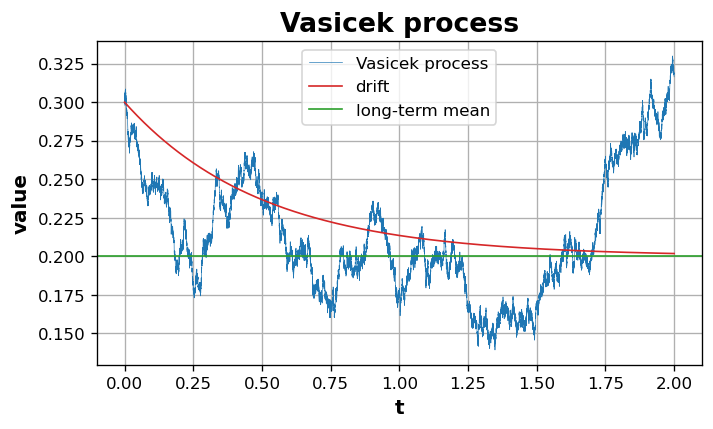

In [22]:
plt.plot(ts, rs, color="tab:blue", lw=0.4, label="Vasicek process")
plt.plot(ts, drift, color="tab:red", lw=1, label="drift")
plt.axhline(b, color="tab:green", lw=1, label="long-term mean")
plt.grid(0.5)
plt.xlabel("t", fontdict={"size":12, "weight":"bold"})
plt.ylabel("value", fontdict={"size":12, "weight":"bold"})
plt.title("Vasicek process", fontdict={"size":16, "weight":"bold"})
plt.legend()
plt.show()

### Ornstein-Uhlenbeck process

The Vasicek model can be considered as a generalization of the **Ornstein-Uhlenbeck process** defined by the SDE
$$
dX_t=-\theta X_t\,dt+\sigma\,dW_t,\quad t\geqslant 0,
$$
with $\theta>0$ and $\sigma>0$. From the formula for the solution of the SDE defining the Vasicek model, we can obtain the following formula for the Ornstein-Uhlenbeck process:
$$
X_t=X_0e^{-\theta t}+\sigma e^{-\theta t}\int_0^t e^{\theta s}\,dW_s.
$$
The martingale
$$
M_t=\sqrt{2\theta}\int_0^t e^{\theta s}\,dW_s,\quad t\geqslant 0,
$$
has quadratic variation
$$
\left\langle M\right\rangle_t=2\theta\int_0^t e^{2\theta s}\,ds=e^{2\theta t}-1,\quad t\geqslant 0.
$$
By the martingale representation theorem, there exists a Wiener process $\widetilde{W}$ such that the following representation takes place:
$$
M_t=\widetilde{W}(\left\langle M\right\rangle_t),\quad t\geqslant 0,
$$
and so we obtain
$$
X_t=X_0e^{-\theta t}+\dfrac{\sigma}{\sqrt{2\theta}} e^{-\theta t}\widetilde{W}_{e^{2\theta t}-1},\quad t\geqslant 0,
$$
or equivalently
$$
X_t=\left(X_0+\dfrac{\sigma}{\sqrt{2\theta}}\widetilde{W}_{e^{2\theta t}-1}\right)e^{-\theta t},\quad t\geqslant 0.
$$

In [23]:
def Ornstein_Uhlenbeck_process(ts, theta, sigma, X0, seed=None):
    drift = X0 * np.exp(-theta * ts)
    diffusion = sigma * np.exp(-theta * ts) * Ito_integral(ts, np.exp(theta * ts), seed=seed)
    vals = drift + diffusion
    return vals

In [24]:
theta = 2
sigma = 0.1
X0 = 0.5


ts = np.linspace(0, T, N+1, endpoint=True)
Xs = Ornstein_Uhlenbeck_process(ts, theta, sigma, X0, seed=seed)
drift = X0 * np.exp(-theta * ts)

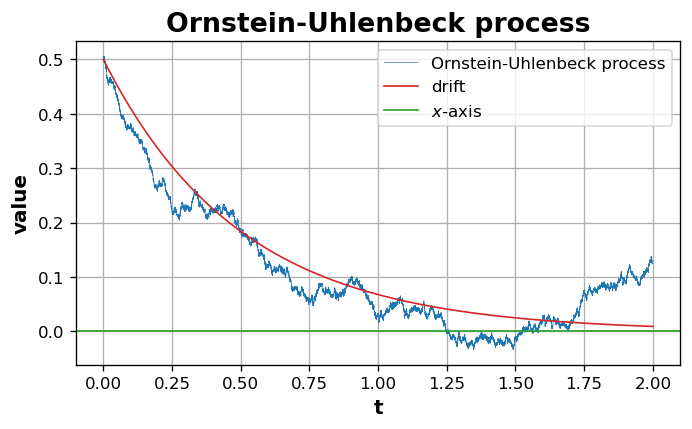

In [25]:
plt.plot(ts, Xs, color="tab:blue", lw=0.4, label="Ornstein-Uhlenbeck process")
plt.plot(ts, drift, color="tab:red", lw=1, label="drift")
plt.axhline(0, color="tab:green", lw=1, label=r"$x$-axis")
plt.grid(0.5)
plt.xlabel("t", fontdict={"size":12, "weight":"bold"})
plt.ylabel("value", fontdict={"size":12, "weight":"bold"})
plt.title("Ornstein-Uhlenbeck process", fontdict={"size":16, "weight":"bold"})
plt.legend()
plt.show()

### Black-Karasinski model

The **Black-Karasinski model** is defined by the SDE
$$
d\ln r_t=(\theta_t-\varphi_t\ln r_t)\,dt+\sigma_t\,dW_t,\quad t\geqslant 0.
$$
Supposing that $\theta_t$, $\varphi_t$ and $\sigma_t$ are constant, we can reduce this model to the Vasicek model. Indeed, let us set
\begin{gather*}
X_t=\ln r_t,\quad t\geqslant 0,\\
a=\varphi,\quad b=\theta/\varphi,
\end{gather*}
we obtain
$$
dX_t=a(b-X_t)\,dt+\sigma\,dW_t,\quad t\geqslant 0,
$$
which is the SDE defining the Vasicek model. Solving this equation, we get an explicit formula for $X_t$, which can then be turned into an explicit formula for $r_t$ using the formula $r_t=e^{X_t}$. Since the Vasicek process $X_t$ has normal distribution for each $t\geqslant 0$, the Black-Karasinski process has log-normal distribution.

In [26]:
def Black_Karasinski_process(ts, theta, phi, sigma, r0, seed=None):
    a = phi
    b = theta / phi
    new_r0 = np.exp(r0)
    vals = Vasicek_process(ts, a, b, sigma, new_r0, seed=seed)
    vals = np.exp(vals)
    return vals

In [27]:
theta = 0.2
phi = 0.2
sigma = 0.3
r0 = 0.05


ts = np.linspace(0, T, N+1, endpoint=True)

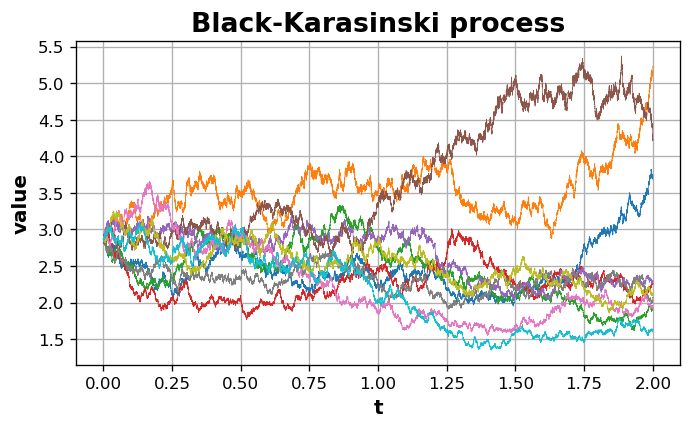

In [28]:
n_samples = 10
colors = sns.color_palette()


for i in range(n_samples):
    rs = Black_Karasinski_process(ts, theta, phi, sigma, r0, seed=i)
    plt.plot(ts, rs, color=colors[i], lw=0.4)

plt.grid(0.5)
plt.xlabel("t", fontdict={"size":12, "weight":"bold"})
plt.ylabel("value", fontdict={"size":12, "weight":"bold"})
plt.title("Black-Karasinski process", fontdict={"size":16, "weight":"bold"})
plt.show()

### Cox-Ingersoll-Ross model

The **Cox-Ingersoll-Ross model** is defined by the stochastic differential equation
$$
dr_t=a(b-r_t)\,dt+\sigma\sqrt{r_t}\,dW_t,\quad t\geqslant 0,
$$
with initial condition $r_0>0$. The coefficients $a$, $b$ and $\sigma$ are called the **speed of adjustment**, the **mean level** and the **volatility**, respectively.

In the integral form, this equation can be written as
$$
r_t=r_0+\int_0^t a(b-r_s)\,ds+\int_0^t \sigma\sqrt{r_s}\,dW_s,\quad t\geqslant 0.
$$

The Cox-Ingersoll-Ross process does not have an explicit form, and so it has to be simulated using discrete approximation schemes. One can use in particular the following recursive formula for its discrete approximations:
$$
r_{t+\Delta t}=r_t+a(b-r_t)\Delta t+\sigma\sqrt{r_t}\sqrt{\Delta t}\cdot Z+\tfrac{1}{4}\sigma^2\Delta t\cdot(Z^2-1).
$$

In [29]:
def Cox_Ingersoll_Ross_process(ts, a, b, sigma, r0, seed=None):
    if seed != None:
        nr.seed(seed)
    
    dts = np.diff(ts)
    Zs = nr.normal(loc=0, scale=1, size=len(dts))
    
    rs = np.empty(len(ts))
    rs[0] = r0
    
    for i, dt in enumerate(dts):
        r = rs[i]
        Z = Zs[i]
        r = (r + a * (b - r) * dt + sigma * np.sqrt(r) * np.sqrt(dt) * Z +
             1/4 * sigma**2 * dt * (Z**2 - 1))
        rs[i+1] = max(r, 0) # to prevent the values from becoming negative
    
    return rs

In [30]:
a = 0.1
b = 0.2
sigma = 0.3
r0 = 0.1


ts = np.linspace(0, T, N+1, endpoint=True)

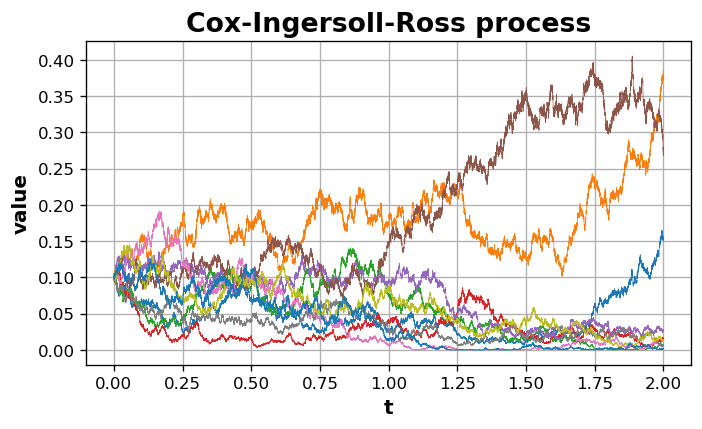

In [31]:
n_samples = 10
colors = sns.color_palette()


for i in range(n_samples):
    rs = Cox_Ingersoll_Ross_process(ts, a, b, sigma, r0, seed=i)
    plt.plot(ts, rs, color=colors[i], lw=0.4)

plt.plot(ts, rs, color="tab:blue", lw=0.4)
plt.grid(0.5)
plt.xlabel("t", fontdict={"size":12, "weight":"bold"})
plt.ylabel("value", fontdict={"size":12, "weight":"bold"})
plt.title("Cox-Ingersoll-Ross process", fontdict={"size":16, "weight":"bold"})
plt.show()